In [2]:
import re
import urllib.request as ur
import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

def get_color_from_partition(partition, G):
    color = dict()
    for idx in range(len(partition)):
        for node in partition[idx]:
            color[node] = idx
    node_color = [color[node] for node in G.nodes()]
    return node_color

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# MMORPG 네트워크 분석

* https://en.wikipedia.org/wiki/List_of_massively_multiplayer_online_role-playing_games

In [3]:
query = 'https://en.wikipedia.org/w/api.php?action=parse&page=List_of_massively_multiplayer_online_role-playing_games&prop=wikitext&format=json'
wikiresponse = ur.urlopen(query)
wikisource = wikiresponse.read()
wikijson = json.loads(wikisource)
wikistr = str(wikijson['parse']['wikitext']['*'])

* 게임 타이틀 하이퍼링크에는 다음과 같은 두 가지 타입이 있다.

type 1. **''[[위키피디아페이지명|표시페이지명]]''**: 해당 페이지에
표시된 이름과 위키피디아 페이지의 이름이 다른 경우

type 2. **''[[페이지명]]''**: 해당 페이지에
표시된 이름과 위키피디아 페이지의 이름이 같은 경우

In [4]:
links_type1 = re.findall(r'\'\'\[\[([^\]\[:]+)\|([^\]\[:]+)\]\]\'\'', wikistr)
print(links_type1)

[('Aion (video game)', 'Aion'), ('Blood Wars (video game)', 'Blood Wars'), ('Boundless (video game)', 'Boundless'), ('Evernight Games', 'Canon / Monarchy'), ('Dark Ages (1999 video game)', 'Dark Ages'), ('Dark and Light (2006 video game)', 'Dark and Light'), ('Defiance (video game)', 'Defiance'), ('Final Fantasy XIV (2010 video game)', 'Final Fantasy XIV (original)'), ('Final Fantasy XIV', 'Final Fantasy XIV (A Realm Reborn)'), ('Firefall (video game)', 'Firefall'), ('Hattrick (video game)', 'Hattrick'), ('Identity (video game)', 'Identity'), ('Jade Dynasty (video game)', 'Jade Dynasty'), ('Lineage (computer game)', 'Lineage'), ('Lost Ark (video game)', 'Lost Ark'), ('Love (2010 video game)', 'Love'), ('Mabinogi (game)', 'Mabinogi'), ('Marvel Heroes (video game)', 'Marvel Heroes'), ('Mythos (computer game)', 'Mythos'), ('Neverwinter (video game)', 'Neverwinter'), ('New World (video game)', 'New World'), ('Omerta (video game)', 'Omerta'), ('Pardus (video game)', 'Pardus'), ('Perfect Wor

In [5]:
links_type2 = re.findall(r'\'\'\[\[([^\]\[:\|]+)\]\]\'\'', wikistr)   
print(links_type2)

['The 4th Coming', 'AdventureQuest 3D', 'AdventureQuest Worlds', 'Age of Conan', 'Age of Wulin', 'AIKA Online', 'Albion Online', 'Allods Online', 'Anarchy Online', 'Angels Online', 'ArcheAge', 'Ashen Empires', "Asheron's Call", "Asheron's Call 2", 'Astonia III', 'Atlantica Online', 'Aura Kingdom', 'Battle of the Immortals', 'Battlestar Galactica Online', 'Battlestar Galactica', 'Black Desert Online', 'Blade & Soul', 'Cabal Online', 'Camelot Unchained', 'Champions of Regnum', 'Champions Online', 'City of Heroes', 'City of Villains', 'Clan Lord', 'CrimeCraft', 'Clone Wars Adventures', 'Dark Age of Camelot', 'Darkeden', 'Darkfall', 'Darkfall Unholy Wars', 'DarkSpace', 'DC Universe Online', 'Dead Frontier', 'Digimon Battle Online', 'Digimon Masters', 'Dofus', 'Domain of Heroes', 'Dragon Ball Online', 'Dragon Nest', 'Dragon Oath', 'Demi-Gods and Semi-Devils', 'Dragon Quest X', 'Dragon Saga', "Dragon's Prophet", 'Drakensang Online', 'Dungeons & Dragons Online', 'Dynasty Warriors Online', 'Ea

* set 함수를 사용하여 집합 형태로 합친 후 리스트로 변형하여 중복된 노드를 삭제한다.

In [6]:
nodes = list(set([x[0] for x in links_type1] + links_type2))
print(nodes)

['Darkeden', 'AdventureQuest 3D', 'MonsterMMORPG', 'Final Fantasy XIV', 'EVE Online', 'Champions of Regnum', 'Champions Online', "Asheron's Call 2", 'Battlestar Galactica', 'MapleStory 2', 'Dofus', 'Wizardry Online', 'Wonderland Online', 'Tabula Rasa (video game)', 'Mabinogi (game)', 'Drakensang Online', 'Age of Conan', 'Dragon Ball Online', 'Omerta (video game)', 'Eternal Lands', 'Dead Frontier', 'WonderKing Online', 'Mortal Online', 'Rift (video game)', 'WildStar (video game)', 'Battle of the Immortals', 'Pirates of the Caribbean Online', 'Minions of Mirth', 'PlaneShift (video game)', 'Dungeons & Dragons Online', 'Eden Eternal', 'New World (video game)', 'Space Heroes Universe!', 'A Tale in the Desert', 'Dynasty Warriors Online', 'Atlantica Online', 'Blood Wars (video game)', 'StarQuest Online', 'Elyon (video game)', 'Dark and Light (2006 video game)', 'City of Heroes', 'Fallen Earth', 'Rusty Hearts', 'Illyriad', 'Aura Kingdom', 'Guild Wars', 'Blade & Soul', 'Echo of Soul', 'Love (20

# MMORPG 네트워크 생성

* 노드: MMORPG 게임 타이틀
* 엣지: 하이퍼링크 관계. A의 위키피디아 페이지에 B가 언급되었으면 유향 엣지 A->B 생성

In [7]:
edges = list()

for node in nodes:
    try:
        query = 'https://en.wikipedia.org/w/api.php?action=parse&page=' + node.replace(" ", "_") +'&prop=wikitext&format=json'
        wikiresponse = ur.urlopen(query)
        wikisource = wikiresponse.read()
        wikijson = json.loads(wikisource)
        wikistr = str(wikijson['parse']['wikitext']['*'].encode('utf-8'))

        links_type1 = re.findall(r'\[\[([^\]\[:]+)\|([^\]\[:]+)\]\]', wikistr)
        links_type2 = re.findall(r'\[\[([^\]\[:\|]+)\]\]', wikistr)
        links = list(set([x[0] for x in links_type1] + links_type2))

        for link in links:
            if link in nodes and link != node:
                print('%s -> %s' % (node, link))
                edges.append((node, link))
                
    except Exception as e:
        print("Error occured at", node, e)

Final Fantasy XIV -> Dragon Quest X
Final Fantasy XIV -> World of Warcraft
Final Fantasy XIV -> Final Fantasy XIV (2010 video game)
Final Fantasy XIV -> Final Fantasy XI
Final Fantasy XIV -> EverQuest
Champions of Regnum -> Dark Age of Camelot
Champions Online -> City of Villains
Champions Online -> City of Heroes
Champions Online -> Star Trek Online
Battlestar Galactica -> Battlestar Galactica Online
MapleStory 2 -> MapleStory
Dofus -> Wakfu
Age of Conan -> Anarchy Online
WonderKing Online -> MapleStory
Mortal Online -> Ultima Online
Rift (video game) -> World of Warcraft
WildStar (video game) -> World of Warcraft
Pirates of the Caribbean Online -> Toontown Online
City of Heroes -> Champions Online
Aura Kingdom -> Eden Eternal
Guild Wars -> Guild Wars 2
Dragon Oath -> Demi-Gods and Semi-Devils
Fantasy Westward Journey -> Journey to the West
Grand Chase -> Elsword
The Legend of Mir 2 -> The Legend of Mir 3
MapleStory -> MapleStory 2
Zhengtu -> Fantasy Westward Journey
The Lord of the R

생성 유향 네트워크 :: 노드 수: 208 | 엣지 수: 113


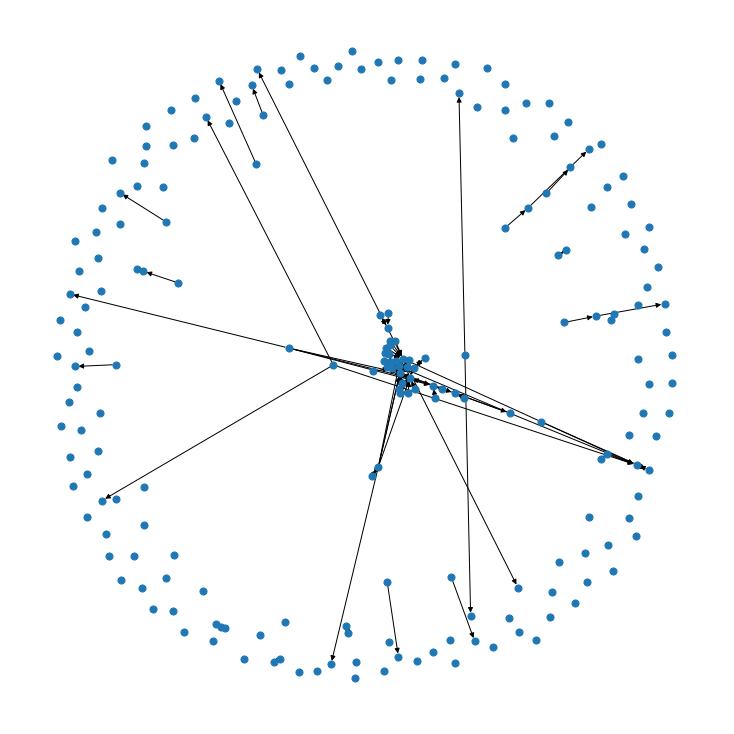

In [8]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
print("생성 유향 네트워크 :: 노드 수: %d | 엣지 수: %d" %(G.number_of_nodes(), G.number_of_edges()))
fig = plt.figure(figsize=(10,10))
nx.draw_spring(G, node_size=50)
plt.show()

# 차수 분포
* 내차수 분포

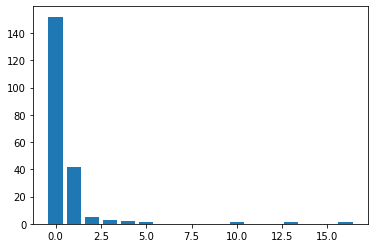

In [9]:
in_degrees = list(dict(G.in_degree()).values())
x = range(0,max(in_degrees)+1)
in_degree_freq = [in_degrees.count(i) for i in x]
plt.bar(x, in_degree_freq)
plt.show()

* 외차수 분포

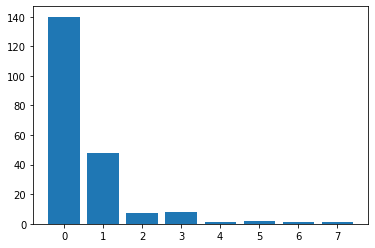

In [10]:
out_degrees = list(dict(G.out_degree()).values())
x = range(0,max(out_degrees)+1)
out_degree_freq = [out_degrees.count(i) for i in x]
plt.bar(x, out_degree_freq)
plt.show()

# 노드 중심성

In [11]:
indeg_centrality = nx.in_degree_centrality(G)
outdeg_centrality = nx.out_degree_centrality(G)
betw_centrality = nx.betweenness_centrality(G)
top5 = sorted(indeg_centrality.items(), key=lambda item: item[1], reverse=True)[0:5]
print("Indegree Centrality Top 5\n", top5)
top5 = sorted(outdeg_centrality.items(), key=lambda item: item[1], reverse=True)[0:5]
print("Outdegree Centrality Top 5\n", top5)
top5 = sorted(betw_centrality.items(), key=lambda item: item[1], reverse=True)[0:5]
print("Betweenness Centrality Top 5\n", top5)

Indegree Centrality Top 5
 [('World of Warcraft', 0.07729468599033816), ('EverQuest', 0.06280193236714976), ('Ultima Online', 0.04830917874396135), ('Guild Wars 2', 0.024154589371980676), ('Dark Age of Camelot', 0.01932367149758454)]
Outdegree Centrality Top 5
 [('EverQuest', 0.033816425120772944), ('Darkfall', 0.02898550724637681), ('Final Fantasy XIV', 0.024154589371980676), ('Ultima Online', 0.024154589371980676), ("Asheron's Call", 0.01932367149758454)]
Betweenness Centrality Top 5
 [('EverQuest', 0.00824304676140894), ('Ultima Online', 0.005358566671356878), ('Dark Age of Camelot', 0.004103935087472445), ('Anarchy Online', 0.00370526710754655), ('World of Warcraft', 0.0029548332629801602)]


# 커뮤니티 탐지

최대 연결 부분 네트워크 :: 노드 수: 44 | 엣지 수: 82
커뮤니티 개수: 5
커뮤니티의 구성원 수: [12, 12, 8, 7, 5]


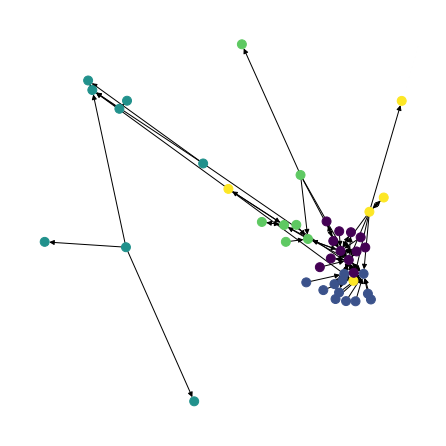

In [12]:
largest = max(nx.weakly_connected_components(G),key=len)
G_largest = G.subgraph(largest)
print("최대 연결 부분 네트워크 :: 노드 수: %d | 엣지 수: %d" %(G_largest.number_of_nodes(), G_largest.number_of_edges()))
G_largest_undirected = G_largest.to_undirected()
partition = list(community.greedy_modularity_communities(G_largest_undirected))
print("커뮤니티 개수:", len(partition))
print("커뮤니티의 구성원 수:", [len(x) for x in partition])
fig = plt.figure(figsize=(6,6))
nx.draw_spring(G_largest, node_size=80, node_color=get_color_from_partition(partition, G_largest_undirected))
plt.show()

# 커뮤니티별 워드클라우드
* 하이퍼링크 내에 refernce, 표, 필요없는 문자 등을 지우고 text 부분만을 추출
* 중요하지 않거나 당연히 언급되는 단어들을 삭제
* 불용어와 중요하지 않은 단어 삭제 후 표제어 추출

Community #0


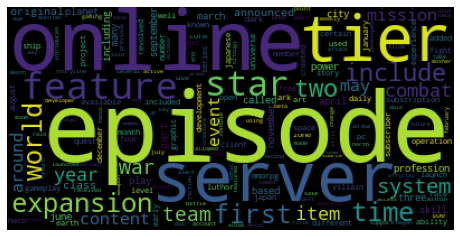

Community #1


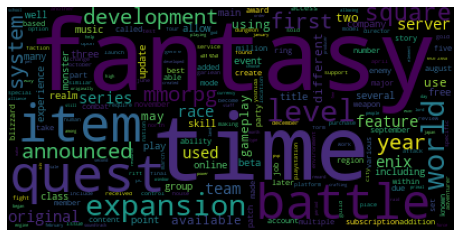

Community #2


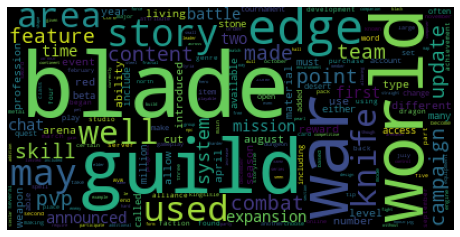

Community #3


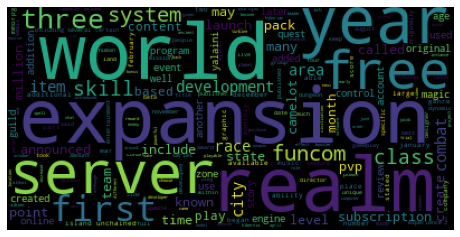

Community #4


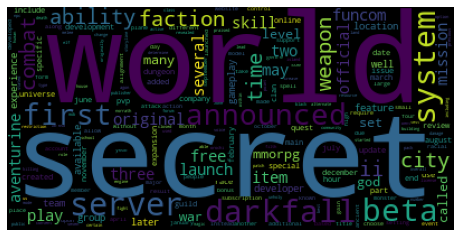

In [16]:
for i in range(len(partition)):
    print("Community #%d" %i)
    text = ""
    for node in partition[i]:
        query = 'https://en.wikipedia.org/w/api.php?action=parse&page=' + node.replace(" ", "_") +'&prop=wikitext&format=json'
        wikiresponse = ur.urlopen(query)
        wikisource = wikiresponse.read()
        wikijson = json.loads(wikisource)
        wikistr = str(wikijson['parse']['wikitext']['*'].encode('utf-8'))
        wikistr = re.sub("<ref>.*?</ref>", " ", wikistr)   
        wikistr = re.sub("{\|.*?\|}", " ", wikistr)
        wikistr = re.sub("[\[{<].*?[\]}>]", " ", wikistr)
        text += wikistr

    stopwords_en = stopwords.words('english')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    irrelevant = ["game", "character", "characters", "player", "released", "version", "players", "release", "new", "one", "games"]  

    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_en + irrelevant]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if re.fullmatch('[a-z]{2,}', t)]

    wc = WordCloud(collocations=False).generate(' '.join(tokens))     
    fig = plt.figure(figsize=(8,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

# 케이스 별 커뮤니티 출력

0 번 커뮤니티 구성원: ['Astonia III', 'Phantasy Star Online 2', 'Shadowbane', 'Meridian 59', 'EverQuest', 'DC Universe Online', 'Star Wars Galaxies', 'Ultima Online', 'The Realm Online', 'Mortal Online', 'Phantasy Star Online', 'Ashen Empires']


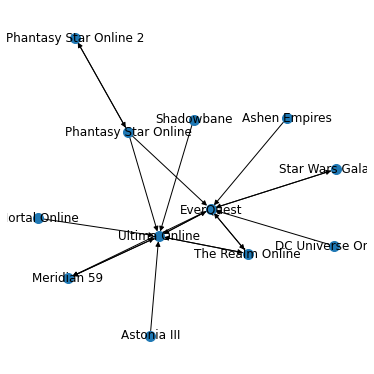

1 번 커뮤니티 구성원: ['WildStar (video game)', 'The Lord of the Rings Online', 'Dragon Quest X', 'Final Fantasy XIV (2010 video game)', 'Fragoria', 'World of Warcraft', 'Final Fantasy XI', 'Final Fantasy XIV', 'Hello Kitty Online', 'Fantasy Earth Zero', 'Rift (video game)', 'Old School RuneScape']


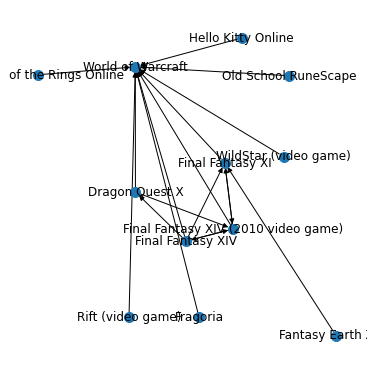

2 번 커뮤니티 구성원: ['Pirate101', 'Black Desert Online', 'Firefall (video game)', 'Wizard101', 'Guild Wars 2', 'Guild Wars', 'Blade & Soul', 'Lost Ark (video game)']


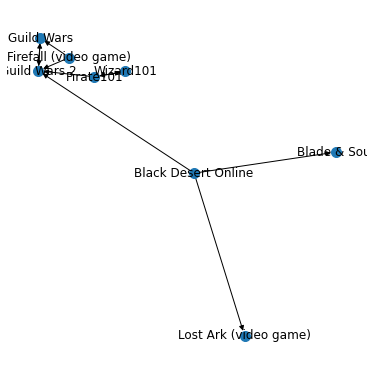

3 번 커뮤니티 구성원: ['Dungeons & Dragons Online', 'Camelot Unchained', 'Champions of Regnum', 'Dark Age of Camelot', "Asheron's Call", 'Anarchy Online', 'Age of Conan']


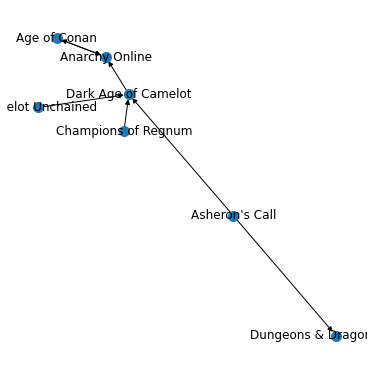

4 번 커뮤니티 구성원: ['EverQuest II', 'Darkfall Unholy Wars', 'Darkfall', 'The Secret World', 'Wurm Online']


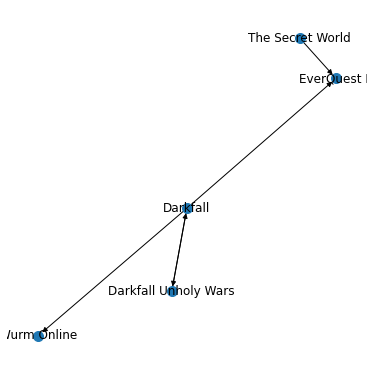

In [14]:
for i in range(5):
    print(i, "번 커뮤니티 구성원:", list(partition[i]))
    community = G.subgraph(list(partition[i]))
    fig = plt.figure(figsize=(5,5))
    nx.draw_spring(community, with_labels=True, node_size=100)
    plt.show()

# EverQuest 워드클라우드

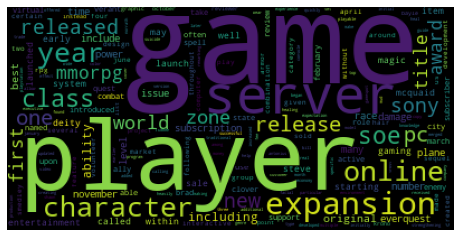

In [17]:
node = "EverQuest"

query = 'https://en.wikipedia.org/w/api.php?action=parse&page=' + node.replace(" ", "_") +'&prop=wikitext&format=json'
wikiresponse = ur.urlopen(query)
wikisource = wikiresponse.read()
wikijson = json.loads(wikisource)
wikistr = str(wikijson['parse']['wikitext']['*'].encode('utf-8'))
wikistr = re.sub("<ref>.*?</ref>", " ", wikistr)
wikistr = re.sub("{\|.*?\|}", " ", wikistr)
wikistr = re.sub("[\[{<].*?[\]}>]", " ", wikistr)
text = wikistr

stopwords_en = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

text = text.lower()
tokens = nltk.word_tokenize(text)
tokens = [t for t in tokens if t not in stopwords_en] 
tokens = [lemmatizer.lemmatize(t) for t in tokens] 
tokens = [t for t in tokens if re.fullmatch('[a-z]{2,}', t)]

wc = WordCloud(collocations=False).generate(' '.join(tokens))     
fig = plt.figure(figsize=(8,8)) 
plt.imshow(wc)
plt.axis("off")
plt.show()